In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel

/Users/gael/git-repos/notebooks/book_genre_detection/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./data.csv')

In [3]:
df

,book,words
0,./data/cook_book_one.txt,project gutenberg's the whitehouse cookbook by...
1,./data/cook_book_three.txt,the project gutenberg ebook of new royal cook ...
2,./data/gothic_novel_four.txt,the project gutenberg ebook of the works of ed...
3,./data/gothic_novel_six.txt,the project gutenberg ebook of northanger abbe...
4,./data/gothic_novel_two.txt,project gutenberg’s the complete works of will...
5,./data/gothic_novel_three.txt,the project gutenberg ebook of dracula by bram...
6,./data/cook_book_four.txt,the project gutenberg ebook of the italian coo...
7,./data/gothic_novel_ten.txt,the project gutenberg ebook of the castle of o...
8,./data/gothic_novel_eight.txt,the project gutenberg ebook of the vampyre a t...
9,./data/gothic_novel_nine.txt,the project gutenberg ebook of the masque of t...


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
text = ['love', 'hate']

In [7]:
encoded_input = tokenizer(text, return_tensors='pt')

In [8]:
encoded_input

{'input_ids': tensor([[ 101, 2293,  102],
        [ 101, 5223,  102]]), 'token_type_ids': tensor([[0, 0, 0],
        [0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1],
        [1, 1, 1]])}

In [9]:
output = model(**encoded_input)

In [10]:
output.last_hidden_state.shape

torch.Size([2, 3, 768])

In [11]:
output.last_hidden_state

tensor([[[-0.1931,  0.2282, -0.1564,  ..., -0.6209, -0.0099,  0.2842],
         [ 0.3865,  0.3619,  0.2342,  ..., -0.9576, -0.0633, -0.4696],
         [ 0.8001,  0.1751, -0.2877,  ..., -0.0113, -0.7751, -0.2699]],

        [[-0.2322,  0.4478, -0.2562,  ..., -0.1797,  0.0831,  0.0075],
         [ 0.3562,  0.3625, -0.2206,  ...,  0.2490,  0.4487,  0.0989],
         [ 0.7516,  0.0380, -0.2849,  ..., -0.0262, -0.8469, -0.4179]]],
       grad_fn=<NativeLayerNormBackward0>)

In [12]:
love_embedding = output.last_hidden_state[0][1]
hate_embedding = output.last_hidden_state[1][1]

In [13]:
# love_embedding.detach().numpy()

In [14]:
# love_embedding

In [15]:
x = [love_embedding.detach().numpy(), hate_embedding.detach().numpy()]
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [16]:
principalDf

,principal component 1,principal component 2
0,5.930534,9.285657e-16
1,-5.930534,9.285657e-16


In [17]:
# TODO: check for correct embedding
# TODO: make sure pca is working the way its supposed to be
# TODO: make good visuals (categories)

In [18]:
cosine_similarity(love_embedding.detach().numpy().reshape(1,-1), hate_embedding.detach().numpy().reshape(1, -1))

array([[0.7019417]], dtype=float32)

# Smaller Example

In [19]:
data = pd.read_csv('./words.csv')

In [20]:
data.head()

,word,label
0,loved,positive
1,terrific,positive
2,admired,positive
3,jolly,positive
4,brave,positive


In [21]:
# tokenize every word in the dataframe
encoded_data = [tokenizer(i, return_tensors='pt') for i in data.word]

In [22]:
encoded_data[0]

{'input_ids': tensor([[ 101, 3866,  102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

In [23]:
# get the word embeddings for each word
word_embeddings = [model(**i) for i in encoded_data]

In [24]:
word_embeddings[0].last_hidden_state.shape

torch.Size([1, 3, 768])

In [25]:
# word_embeddings[0].last_hidden_state[0][1]

In [26]:
embeddings = [i.last_hidden_state for i in word_embeddings]

In [27]:
embeddings = [i[0][1] for i in embeddings]

In [28]:
embeddings = [i.detach().numpy() for i in embeddings]

In [29]:
data['word_embeddings'] = embeddings

In [30]:
love_embedding.detach().numpy().shape

(768,)

In [31]:
embeddings[0].shape

(768,)

In [32]:
data.head()

,word,label,word_embeddings
0,loved,positive,"[0.5129337, -0.04044947, 0.42860067, -0.150437..."
1,terrific,positive,"[0.33330074, -0.20869645, -0.1652221, -0.06318..."
2,admired,positive,"[-0.25650117, 0.022439487, 0.25480837, -0.0880..."
3,jolly,positive,"[-0.22022378, -0.20243269, 0.10135959, -0.3264..."
4,brave,positive,"[-0.08306722, -0.11899652, -0.46022692, -0.438..."


In [33]:
p_c_a = PCA(n_components=2)
principal_components = p_c_a.fit_transform(list(data.word_embeddings))
principal_df = pd.DataFrame(data = principal_components, columns=['pc_one', 'pc_two'])

In [34]:
principal_df.head()

,pc_one,pc_two
0,-2.438594,-0.386256
1,-1.084823,0.115701
2,-2.641706,0.350935
3,-4.381246,0.961058
4,-2.861545,0.087099


In [35]:
positive_words = principal_df.head(25)
negative_words = principal_df.tail(25)

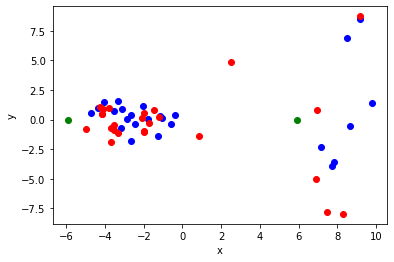

In [36]:
plt.scatter(positive_words.pc_one, positive_words.pc_two, color='b')
plt.scatter(negative_words.pc_one, negative_words.pc_two, color='r')
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], color='g')
plt.xlabel('x')
plt.ylabel('y')
plt.show();

NameError: name 'X_embedded' is not defined